# Parameter Estimation

In [1]:
import sys
sys.path.append('../datasets') 
import dataset_long as dsl

sys.path.append('../fitting') 
import paramfitt_singlePatient as pf 

# Model
import numpy as np
import tellurium as te
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
# Dataframe
import pandas as pd

#Estimation

from scipy.optimize import minimize 
from collections import OrderedDict
from scipy.stats import qmc
from scipy.optimize import basinhopping
#Analyse Estimation
from scipy.stats import chi2
from scipy.stats import norm

# Save optimization params
import json
import time

### import charite-Data and  Model

In [2]:
#import Data of charite
df = pd.read_excel('.././datasets/haemolysismodel_conRetis.xlsx')
df = dsl.long_format(df)
#df_long[['time','measurement','patientnumber']].head(10)
#df.head(21)


<Axes: xlabel='time', ylabel='[oiE]'>

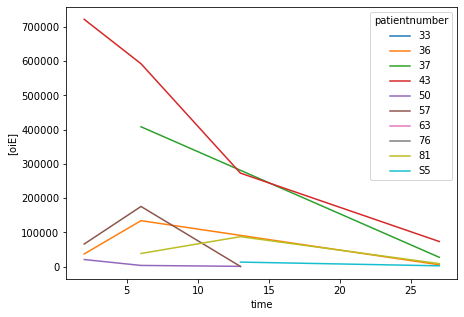

In [3]:
# PTH patient 

#soll keine Nan in Hb Werten haben
df_sinHbNan = df.copy()
df_sinHbNan = df_sinHbNan.groupby(['patientnumber']).filter(lambda group: ~(group['Hb'].isnull().any()))
#df_sinHbNan = df_sinHbNan.groupby(['patientnumber']).filter(lambda group: ~((group['[oiE]'].isnull()& (group['time'] != 0)).any()))
df_PTH = df_sinHbNan.groupby('patientnumber').filter(lambda group: (group['PTH'] == 1).any())

#außerdem viele Werte in LDH, R, oiE, ..

plt.figure( figsize=(7,5))
sns.lineplot(x='time', y='[oiE]', hue='patientnumber', data =df_PTH)#, legend='')

35

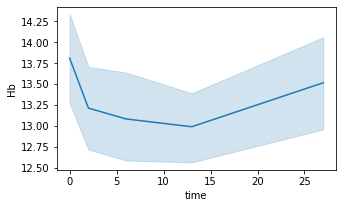

In [4]:
#non PTH patient

#letzter Wert nicht wichtig, alle patienten raus die Nan in Hb werten haben (außer letzter)
df_sinHbNan = df.copy()


#df_sinHbNan = df_sinHbNan.groupby(['patientnumber']).filter(lambda group: ~((group['Hb'].isnull() & (group['time'] != 27)).any()))
#df_sinHbNan = df_sinHbNan.groupby(['patientnumber']).filter(lambda group: ~((group['RPI'].isnull()& (group['time'] != 27)).any()))
#df_sinHbNan = df_sinHbNan.groupby(['patientnumber']).filter(lambda group: ~((group['LDH'].isnull()& (group['time'] != 27)).any()))
#df_sinHbNan = df_sinHbNan.groupby(['patientnumber']).filter(lambda group: ~((group['[oiE]'].isnull() & (group['time'] != 0) & (group['time'] != 27)).any()))

df_noPTH = df_sinHbNan.groupby('patientnumber').filter(lambda group: (group['PTH'] == 0).any())


plt.figure( figsize=(5,3))
sns.lineplot(x='time', y='Hb',  data =df_noPTH)#, legend='') hue='patientnumber',

len(df_noPTH["patientnumber"].unique())

10

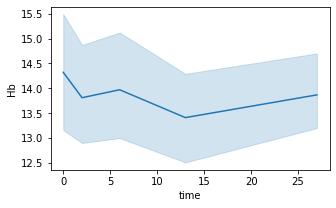

In [5]:
#non PTH patient

#letzter Wert nicht wichtig, alle patienten raus die Nan in Hb werten haben (außer letzter)
df_sinHbNan = df.copy()


df_sinHbNan = df_sinHbNan.groupby(['patientnumber']).filter(lambda group: ~((group['Hb'].isnull() & (group['time'] != 27)).any()))
df_sinHbNan = df_sinHbNan.groupby(['patientnumber']).filter(lambda group: ~((group['RPI'].isnull()& (group['time'] != 27)).any()))
df_sinHbNan = df_sinHbNan.groupby(['patientnumber']).filter(lambda group: ~((group['LDH'].isnull()& (group['time'] != 27)).any()))
df_sinHbNan = df_sinHbNan.groupby(['patientnumber']).filter(lambda group: ~((group['[oiE]'].isnull() & (group['time'] != 0) & (group['time'] != 27)).any()))

df_noPTH = df_sinHbNan.groupby('patientnumber').filter(lambda group: (group['PTH'] == 0).any())


plt.figure( figsize=(5,3))
sns.lineplot(x='time', y='Hb',  data =df_noPTH)#, legend='') hue='patientnumber',

len(df_noPTH["patientnumber"].unique())


<Axes: xlabel='time', ylabel='LDH'>

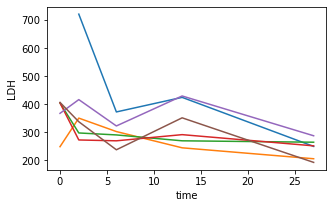

In [6]:
patient_numbers_to_keep = ['51', '61','59', '36', '63', '76']
df_selected = df[df['patientnumber'].isin(patient_numbers_to_keep)]



plt.figure( figsize=(5,3))
sns.lineplot(x='time', y='LDH', hue='patientnumber', data =df_selected, legend='')

#df_selected


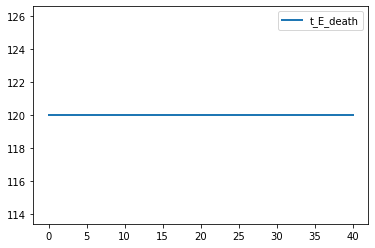

In [7]:
# load model from ant-Data
model = te.loada('.././model/OIE_model.ant')

result = model.simulate(0, 40, 101, ['time', 't_E_death'])
# Plot results
model.plot(result)

### Preprocessing Charite-Data for Estimation

In [8]:
#PADh/non-PADh as mean of all PADH vs non-PADH pattients

# Define lab values to fit in the model
lab_values = [
       'parasitemia',
       #'PfHRP2', 
       'Hkt', 
       '[E]', 
       'Hb',
       'LDH',
       '[R]',
       'R_percent',
       'oiE_percent', 
       '[oiE]',
       '[iE]' 
       #'Pittingquote_absolut_modified',
       #'Pittingquote_modified',
       ]

columns_to_check = [
       '[E]', 

       ]



In [9]:

# Create DataFrame with only PTH cases and group it by time, then calculate mean, standard deviation, and SEM of each lab value
df_PTH = df.loc[df['PTH'] == 1]                                                 
df_input_PTH= df_PTH.groupby('time')[lab_values].agg(['mean', 'std', 'sem'])              # group the dataframe df by the 'time' and calculate  mean, standard deviation and SEM of each lab-value
df_input_PTH.columns = ['{}_{}'.format(col, stat) for col, stat in df_input_PTH.columns]  # rename columns of the resulting df to 'Hb_mean', 'Hb_std', ...

# Create a DataFrame with only non-PTH cases and group it by time, then calculate mean, standard deviation, and SEM of each lab value
df_noPTH = df.loc[df['PTH'] == 0]                                                 
df_input_noPTH= df_noPTH.groupby('time')[lab_values].agg(['mean', 'std', 'sem'])             # group the dataframe df by the 'time' and calculate  mean, standard deviation and SEM of each lab-value
df_input_noPTH.columns = ['{}_{}'.format(col, stat) for col, stat in df_input_noPTH.columns] # rename columns of the resulting df to 'Hb_mean', 'Hb_std', ...



### Calculate Residual Error

In [10]:
"""
#Parameter
params = OrderedDict({'param2_EPOprod': 200, 'param3_EPOprod': 0.1})

#import model
ant_model = '.././model/OIE_model.ant'

#import data from charite + preprocessing for param estimation
data_df = pd.read_excel('.././datasets/haemolysismodel_conRetis.xlsx')   
df = dsl.long_format(data_df)
df_experimental_data = pf.preprocess_experimental_df(df,1, pf.get_lab_values())

#Residual Error
res_error = pf.objectiv_function(params.values(), df_experimental_data, ant_model, params.keys())
print(res_error)

"""
ant_model = '.././model/OIE_model.ant'

### Plotting Simulation and Experimental Data

In [11]:

df_filtered = df.loc[df['PTH'] == 1 ]                                                 
df_experiment_data= df_filtered.groupby('time')[lab_values].agg(['mean', 'std', 'sem'])              # group the dataframe df by the 'time' and calculate  mean, standard deviation and SEM of each lab-value
df_experiment_data.columns = ['{}_{}'.format(col, stat) for col, stat in df_experiment_data.columns]  # rename columns of the resulting df to 'Hb_mean', 'Hb_std', ...

df_input_PTH = df_experiment_data

In [12]:
def plot_simulation_and_experiment(data_df, sim_df, figsize=(10, 6)):
    n_subplots = len(sim_df.columns)
    n_cols = 3
    n_rows = int(np.ceil(n_subplots/n_cols))

    fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=figsize)

    for i, lab_value in enumerate(sim_df.columns):
        col = i%n_cols
        row = i//n_cols
        ax[row, col].plot(sim_df.index, sim_df[lab_value])
        ax[row, col].errorbar(data_df.index, data_df[f"{lab_value}_mean"], yerr=data_df[f"{lab_value}_std"], fmt='o')
        ax[row, col].set_title(lab_value)
    plt.tight_layout()
    plt.show()



    
lab_values = pf.get_lab_values()
df_simulated_data = pf.simulate_model('.././model/OIE_model.ant' , lab_values)


TypeError: argument of type 'NoneType' is not iterable

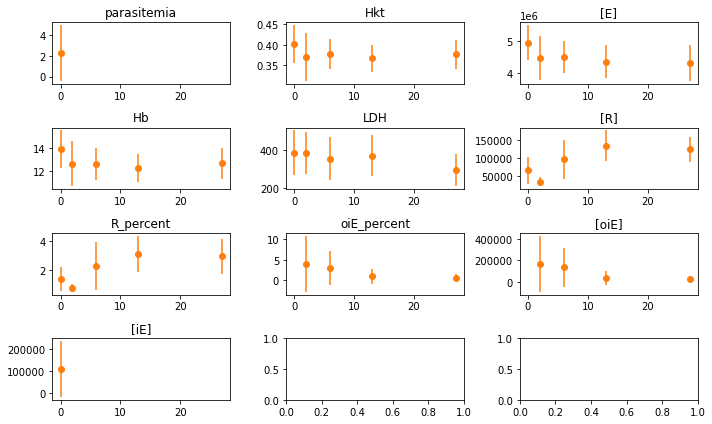

,parasitemia,Hkt,[E],Hb,LDH,[R],R_percent,oiE_percent,[oiE],[iE]
0,5.513636e+00,0.411025,4.792316e+06,12.989046,365.440598,50324.322525,0.981895,0.000000,0.000000,2.825864e+05
1,6.282827e-01,0.398107,4.708516e+06,12.789163,481.639601,55449.179601,1.095291,5.268781,266732.283741,3.180684e+04
2,3.057095e-02,0.396664,4.709998e+06,12.768989,453.715633,58009.423678,1.149076,5.522630,278801.868388,1.543329e+03
3,7.550575e-04,0.396589,4.720350e+06,12.768283,414.756145,58907.756128,1.168656,5.184787,261346.552214,3.805975e+01
4,2.781212e-04,0.396607,4.731172e+06,12.769369,380.880124,59194.904747,1.175849,4.843743,243844.955801,1.400125e+01
5,1.024242e-04,0.396669,4.742063e+06,12.771894,351.922166,59276.822435,1.178733,4.524193,227515.388583,5.150772e+00
6,3.771280e-05,0.396774,4.752894e+06,12.775783,327.138794,59285.929163,1.179946,4.224918,212279.363630,1.894865e+00
7,1.388347e-05,0.396920,4.763624e+06,12.780937,305.899466,59265.239380,1.180358,3.944742,198063.649689,6.970827e-01
8,5.110181e-06,0.397102,4.774240e+06,12.787256,287.670690,59228.881858,1.180265,3.682543,184799.919584,2.564426e-01
9,1.880654e-06,0.397318,4.784738e+06,12.794644,272.001424,59181.736392,1.179778,3.437252,172424.421805,9.434007e-02


In [ ]:
lab_values = ['parasitemia', 'Hkt', '[E]', 'Hb','LDH','[R]', 'R_percent','oiE_percent', '[oiE]','[iE]' ]
# load model from ant-Data
model = te.loada('.././model/OIE_model.ant')

ant_model = '.././model/OIE_model.ant'
# Create a dataframe to store the simulated data
df_simulated_data= pd.DataFrame(columns=lab_values)


""" time = list(df_input_PTH.index)
# Simulate model for lab values at each time point in the experimental data
for timepoint in time:
    max_time = int(timepoint + model.t_ART_add)     #simulate time starting with treatment day (in experiments: data 0 == in Model: day 7)
    simulation_result = model.simulate(0, max_time , 100, selections = ['time']+lab_values )
    for lab_value in lab_values:
        df_simulated_data.loc[max_time, lab_value] = simulation_result[lab_value][-1]
 """

#plot_simulation_and_experiment(df_input_PTH, df_simulated_data)

df_sim_plot = pf.simulated_data_for_plot(ant_model, lab_values, params = None)

plot_simulation_and_experiment(df_input_PTH, df_simulated_data)
#plot_simulation_and_experiment(df_input_PTH, df_sim_plot)

display(df_sim_plot)


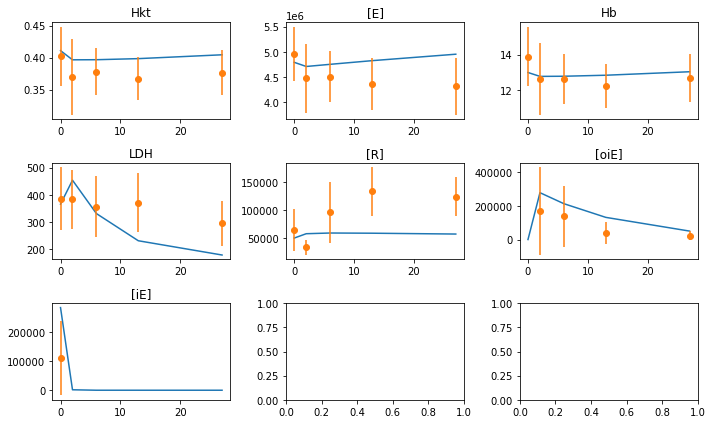

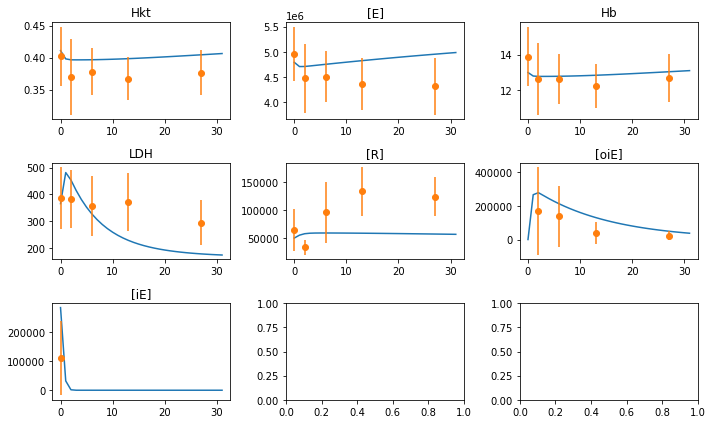

In [ ]:
#Plotting

#Model Daten
ant_model = '.././model/OIE_model.ant'
df_simulated_data = pf.simulate_model('.././model/OIE_model.ant' , pf.get_lab_values())
#sim plot Daten
df_sim_plot = pf.simulated_data_for_plot('.././model/OIE_model.ant', pf.get_lab_values(), params = None)

#experimentelle Daten
data_df = pd.read_excel('.././datasets/haemolysismodel_conRetis.xlsx')   
df = dsl.long_format(data_df)
df_experimental_data = pf.preprocess_experimental_df(df, 1, pf.get_lab_values())

#Plotten
pf.plot_simulation_and_experiment(df_experimental_data, df_simulated_data)
pf.plot_simulation_and_experiment(df_experiment_data, df_sim_plot)


### Optimization 

In [ ]:

#model
ant_model = '.././model/OIE_model.ant'
#experimentelle Daten
data_df = pd.read_excel('.././datasets/haemolysismodel_conRetis.xlsx')   
df = dsl.long_format(data_df)
df_experimental_data = pf.preprocess_experimental_df(df, 1, pf.get_lab_values())


#define an initial guess for the parameter values (add more from model)
params_guess =OrderedDict({
    # 'P':453.37,
    # 'M': 40e3,ID50
    #'k_R_death': 0,
     'k_E_infect': 1e-6 ,
    #'k_iE_death': 0 ,
    'k_iE_rupture':1,
    #'k_diE_death' :0, 
    'k_diE_pitt' : 1, 

    'KI_P_death': 15,
    'param2_EPOprod': 200,
    'param3_EPOprod': 0.1,
    
    'I0_iE':    0.1,    
    'Imax_iE': 10,    
    #'hill' :2.0,      
    'ID50': 45,

    'Hb_conc_iE': 180  ,
    'Hb_conc_diE' : 180,        
    'Hb_conc_oiE': 180,     
    #'LDH_conc_E': 6062.500000000001, 
    't_oiE_death': 10,   
    't_halb_LDH_decay': 10, #4,

    'par1_oiE': 5e-4,
    'par2_oiE': 10000,
    'k_BH': 5e-4,
    'J_oiEdeath_0': 7500,

    })

#define bounds of parameters values
params_bounds =OrderedDict({
    # 'P':(1e1,1e4 ),
    # 'M': (1e2,1e4),
    #'k_R_death': (0, 1.4e-3),            #k_R_death < k_R_aging=1.38, drei einheiten kleiner setzen
     'k_E_infect': (1e-8 , 1e-4),
    #'k_iE_death':  (0,1e-3) ,            #k_iE_death < k_iE_rupture=1, 3 Einheiten kleiner
    'k_iE_rupture':(1e-1, 10),
    #'k_diE_death' :(0,1e-2) ,
    'k_diE_pitt' : (0.1, 5),           # Rate mit der diE gepitted von Milz werden

    'KI_P_death': (0.1, 100),          # bei EPO=15(normalo), k_P_death ist 0.5
    'param2_EPOprod': (0,300),
    'param3_EPOprod': (0,0.5),

    'I0_iE':    (0, 1e-3),            #vlt auf 0 setzen ausprobieren, Inhibition ohne ART, zw. 0 und viel kleiner als Imax_iE 
    'Imax_iE': (1, 1000),             # maximale abtötrate von iE durch ART 
    #'hill' :(1, 4),                 #Anstieg, sehr sensibey= 
    'ID50': (30, 300),               #ART dosis bei der 50% der iE getötet werden       

    'Hb_conc_iE': (180,350)  ,       # Hb Konzentration maximal halbiert von Hb_E = 350
    'Hb_conc_diE': (180,350),        
    'Hb_conc_oiE': (180,350),  
    #'LDH_conc_E':(4000,8000),       # GG berechnet, muss nicht fitten
    't_oiE_death': (5,15),           #Zeit nach der oiE sterben, nach ca. 7- 14
    't_halb_LDH_decay': (2,7),      # Halbwertzeit von LDH, 3-5 Tage+ Puffer

    'par1_oiE': (5e-5, 5e-3),         # Anstieg Kurve 
    'par2_oiE': (1000, 20000),        #max. Daten = 40 000 -> Hälfte=20 000 maximal für y= 0.5 
    'k_BH': (5e-5, 5e-3),    # Anstieg Kurve 
    'J_oiEdeath_0': (5000, 10000)    # in Modell max. 15.000

    })

#def bounds in log-space überführen (kein 0 )---- check

#def latin_hypercube_sampling   --- check


# def get_initalguess(param_space):
#     """
#     input: ordDict: {'param2_EPOprod': (0,300, True),... }
#     return: 
#         param_names: list 
#         bounds: liste
#         intialguess: [[intial_guess1],[initial_guess2]]
#     """
#     # log bounds nutzen ->  create inital guess with sampling with lhc

#print(list(params_guess.values()))


# run the optimization
# try:
#     result = minimize(pf.objectiv_function, x0=list(params_guess.values()), args=(df_experimental_data, ant_model, params_guess.keys()), bounds=list(bounds.values()) )
# except RuntimeError: 
#     pass



# print('Optimal parameter values: ', result.x)
# print('Residual error: ', result.fun)




#### Optimization with minimize (local Search)

In [ ]:
# Estimation with LHS and log-scale 

""" log_bounds= pf.convert_bounds_to_logscale(params_bounds)
num_samples = 10  #number of otimizations to perform
samples = pf.generate_LHS_sampling(log_bounds, num_samples)    
best_objectiv_score = 20
best_paramvalues = []
best_covmatrix = []


for sample in samples:
    intial_guess = pf.create_intial_guess(params_bounds,sample)

    try:
        result = minimize(
            pf.objectiv_function, 
            x0=list(intial_guess.values()), 
            args=(df_experimental_data, ant_model, intial_guess.keys()), # basinhopper: minimizer_kwargs = {'args': (df_experimental_data, ant_model, intial_guess.keys()), 'bounds' :list(log_bounds.values()} 
            bounds=list(log_bounds.values()) 
            )
        
        print(intial_guess)
        print('Optimal parameter values:', result.x)
        print('objectiv score:', result.fun)
        #print('cov_matrix:', result.hess_inv.todense()
        
        if result.fun < best_objectiv_score:
            best_objectiv_score = result.fun 
            best_paramvalues = result.x
            best_covmatrix = result.hess_inv.todense()

    except RuntimeError: 
        pass """



# OrderedDict([('k_R_death', -4.364584452178457), ('k_iE_death', -6.991610432116614), ('k_iE_rupture', -0.24736315779678186), ('k_diE_death', -4.076286290798289), ('param2_EPOprod', -3.8521859637468774), ('param3_EPOprod', -2.615229943484188), ('I0_iE', -0.36083715837554386), ('Imax_iE', -0.9782504036639317), ('Hb_conc_iE', 2.386471684381343), ('Hb_conc_diE', 2.471955499725376), ('Hb_conc_oiE', 2.168780464497412), ('LDH_conc_E', 3.9822959898657113), ('t_oiE_death', 0.82861416878741), ('t_halb_LDH_decay', 0.9116648730488208)])
# Optimal parameter values:  [-4.73558436 -6.77516134  0.15859302 -4.38969621 -3.24543347 -7.85943323
#  -0.41492869  1.90800325  2.04338727  2.          2.          3.89530899
#   0.82861417  0.91166487]
# Residual error:  16.97560290709096

# OrderedDict([('k_R_death', -3.7331553690077195), ('k_diE_pitt', -0.3402399642506534), ('KI_P_death', 1.153854139000697), ('param2_EPOprod', 0.0694267553458221), ('param3_EPOprod', -2.3559677294400596), ('I0_iE', -1.3244590386921575), ('Imax_iE', -0.6351745870166311), ('Hb_conc_iE', 2.2993994084621607), ('Hb_conc_diE', 2.3013922032857477), ('Hb_conc_oiE', 2.483482814316522), ('LDH_conc_E', 3.701618124646825), ('t_oiE_death', 0.8372784513250696), ('t_halb_LDH_decay', 0.5709369386447432), ('par1_oiE', -2.9760546247824484), ('par2_oiE', 4.014911707246718), ('k_BH', -3.8920395694741727), ('J_oiEdeath_0', 3.887208333290494)])
# Optimal parameter values: [-5.45388544 -0.07270453  0.50657611  1.03006835 -0.30103    -2.88413016
#   1.80714798  2.54406804  2.54406804  2.          3.8427543   0.83727845
#   0.57093694 -2.97605462  4.01491171 -3.59925746  3.69897   ]
# objectiv score: 9.167480197702057



" log_bounds= pf.convert_bounds_to_logscale(params_bounds)\nnum_samples = 10  #number of otimizations to perform\nsamples = pf.generate_LHS_sampling(log_bounds, num_samples)    \nbest_objectiv_score = 20\nbest_paramvalues = []\nbest_covmatrix = []\n\n\nfor sample in samples:\n    intial_guess = pf.create_intial_guess(params_bounds,sample)\n\n    try:\n        result = minimize(\n            pf.objectiv_function, \n            x0=list(intial_guess.values()), \n            args=(df_experimental_data, ant_model, intial_guess.keys()), # basinhopper: minimizer_kwargs = {'args': (df_experimental_data, ant_model, intial_guess.keys()), 'bounds' :list(log_bounds.values()} \n            bounds=list(log_bounds.values()) \n            )\n        \n        print(intial_guess)\n        print('Optimal parameter values:', result.x)\n        print('objectiv score:', result.fun)\n        #print('cov_matrix:', result.hess_inv.todense()\n        \n        if result.fun < best_objectiv_score:\n            

In [ ]:
# best_paramvalues = [-6.95260295, -0.12234937 , 0.95522474 , 1.88302127, -5.37169286 ,-7.29927081,
#   2.    ,      2.18154805 , 2.39259173  ,2.0674412  ,3.86027806  ,1.05750816,
#   0.52014416 , 1.8977316 , -6.76966062,  2.81161991 , 1.41779735]#result.x

# best_objectiv_score = chi_square = pf.objectiv_function (best_paramvalues, df_experimental_data, ant_model,params_guess.keys())  #result.fun

# best_covmatrix = 
# #result.hess_inv.todense()

# best_objectiv_score

### Optimization with Basinhopping Algorithm (global Search)

In [ ]:
log_bounds = pf.convert_bounds_to_logscale(params_bounds)
num_samples = 10  # number of LHS samples to generate
samples = pf.generate_LHS_sampling(log_bounds, num_samples)    
best_objectiv_score = 20  #Set the initial best objective score to a high number
best_paramvalues = []
best_covmatrix = []

for sample in samples:
    intial_guess = pf.create_intial_guess(params_bounds, sample)

    try:
        # Perform the optimization using basinhopping
        result = basinhopping(
            pf.objectiv_function,
            x0=list( intial_guess.values()),
            minimizer_kwargs= {
                'args': (df_experimental_data, ant_model, intial_guess.keys()), #minimizer keyword arguments
                'bounds': list(log_bounds.values())
                }
        )

        print(intial_guess)
        print('Optimal parameter values:', result.x)
        print('objectiv score:', result.fun)
        #print('cov_matrix:', result.hess_inv.todense()
        
        if result.fun < best_objectiv_score:
            best_objectiv_score = result.fun 
            best_paramvalues = result.x
            best_covmatrix = result.hess_inv.todense()

    except RuntimeError: 
        pass

## Results Analysis

In [ ]:
# Extract fitting paraemter value and covariance matrix from Fitting
fitted_params = best_paramvalues        #Optimal parameter values
cov_matrix    = best_covmatrix          #Convariance matrix = inverse hesse matrix, todense() makes matrix to dense array, but i dont unterstand why without it only shows adress?? 
objectiv_score= best_objectiv_score

# Calculate Parameter Sensivity
param_std = np.sqrt(np.diag(cov_matrix))  # get diagonal elements from hessian matrix (=variances), then calculate the square roots of variances (=standart deviation -> = sensivity)

# Calculate Parameter Confidence Intervals (95% level)
alpha = 0.05      #significance level, probability of rejecting the null hypothesis when it is actually true
gamma = 1- alpha  #= 0.95 confidence level, probability that the true population parameter lies within the confidence interval
z_value = norm.ppf(1- alpha/2)  # z-value from table for given alpha, divide by 2 because want the z value for only one sider of normal distribution  #1.96

#n = len(df_experimental_data) #??????????????????????????????? FALSCh, muss korrigiert werden, 
#CI = np.array(z_value * param_std / np.sqrt(n))


# Calculate p-value for the goodness of fit
num_experim_points = 40-10   #how to get number of datapoints from dataframe experiments?
deg_freedom = num_experim_points - len(fitted_params)  # Degrees of freedom = N-P
p_value = 1 - chi2.cdf(objectiv_score, deg_freedom)

# Print the results
print("Parameter names:", params_guess.keys())
print("Fitted parameter values:", fitted_params)
print("Parameter sensitivities:", param_std)
#print("Parameter confidence intervals (95% level):", CI)
print("Chi-square value:", objectiv_score)
print("Degrees of freedom:", deg_freedom)
print("p-value for goodness of fit:", p_value)

params.keys()




Parameter names: odict_keys(['k_E_infect', 'k_iE_rupture', 'k_diE_pitt', 'KI_P_death', 'param2_EPOprod', 'param3_EPOprod', 'I0_iE', 'Imax_iE', 'ID50', 'Hb_conc_iE', 'Hb_conc_diE', 'Hb_conc_oiE', 't_oiE_death', 't_halb_LDH_decay', 'par1_oiE', 'par2_oiE', 'k_BH', 'J_oiEdeath_0'])
Fitted parameter values: []
Parameter sensitivities: []
Chi-square value: 20
Degrees of freedom: 30
p-value for goodness of fit: 0.9165415270653372


NameError: name 'params' is not defined

In [ ]:
for i in [-4.73558436, -6.77516134,  0.15859302, -4.38969621, -3.24543347, -7.85943323,
 -0.41492869,  1.90800325,  2.04338727,  2. ,         2. ,         3.89530899,
  0.82861417 , 0.91166487]:
    print(10 ** i)

1.838296837229247e-05
1.6781804598090077e-07
1.4407645694711293
4.076653409453003e-05
0.0005682854410993187
1.3821868919645388e-08
0.38465493617882646
80.91019539905453
110.50635903342534
100.0
100.0
7857.945095255811
6.739290387889875
8.159524861051173


In [ ]:
# Latin Hypercube Sampling (LHS)

# define number of samples to generate
n_samples = 100   

# define sample dimension, i.e. number of parameters
params_log_bounds = pf.convert_bounds_to_logscale(params_bounds)                                           
sample_dim = len(params_log_bounds)   

# Create the sampler object
sampler = qmc.LatinHypercube(d=sample_dim)  

# Generate LHS samples
lhs_log_sample = sampler.random(n=n_samples)

# Scale the samples using the parameter bounds in log10 scale
lower_bounds = [params_log_bounds[param][0] for param in params_log_bounds]
upper_bounds = [params_log_bounds[param][1] for param in params_log_bounds]
lhs_log_sample = qmc.scale(lhs_log_sample, lower_bounds, upper_bounds)

# Convert the samples back to the original space
params_values = OrderedDict({})
for i, (param, bounds) in enumerate(params_log_bounds.items()):
    params_values[param] = 10 ** np.interp(lhs_log_sample[:, i], (0, 1), bounds)

# Print the parameter values for the first 5 samples
for i in range(10):
    print(f'Sample {i}: {params_values["param2_EPOprod"][i]}, {params_values["param3_EPOprod"][i]}')




Sample 0: 300.0000000000001, 0.0004999999999999999
Sample 1: 300.0000000000001, 0.0004999999999999999
Sample 2: 0.4957409175571717, 0.0004999999999999999
Sample 3: 161.1952484257631, 0.0004999999999999999
Sample 4: 0.29999999999999993, 0.0004999999999999999
Sample 5: 300.0000000000001, 0.0004999999999999999
Sample 6: 0.29999999999999993, 0.0004999999999999999
Sample 7: 300.0000000000001, 0.0004999999999999999
Sample 8: 300.0000000000001, 0.0004999999999999999
Sample 9: 58.91088418356803, 0.0004999999999999999


In [ ]:
#Model Daten
ant_model = '.././model/OIE_model.ant'

new_values= [-7.6062386, -0.12404199, 0.60534833, 1.04274623, -0.30103, -7.73253928, 1.96360832, 2.54380708, 2.48182895, 2., 3.85686533, 1.04100965, 0.58049324, 1.6698508, -7.61850443, 2.69407412, 2.77711406]

new_dict = params_guess.copy() 
for idx, key in enumerate(new_dict):
    new_dict[key] = new_values[idx]

df_simulated_data = pf.simulate_model('.././model/OIE_model.ant' , pf.get_lab_values(),new_dict )

#experimentelle Daten
data_df = pd.read_excel('.././datasets/haemolysismodel_conRetis.xlsx')   
df = dsl.long_format(data_df)
df_experimental_data = pf.preprocess_experimental_df(df, 1, pf.get_lab_values())

#Plotten
pf.plot_simulation_and_experiment(df_experimental_data, df_simulated_data)

df_simulated_data

IndexError: list index out of range

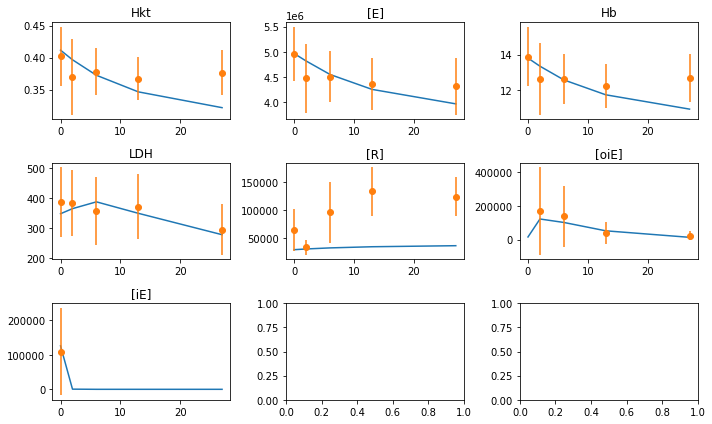

,Hkt,[E],Hb,LDH,[R],[oiE],[iE]
0,0.411756,4.965161e+06,13.802639,347.517592,29684.823992,15270.891271,1.262536e+05
2,0.396715,4.817619e+06,13.344572,364.400994,30953.437971,122231.326398,4.755646e+02
6,0.372496,4.550535e+06,12.569041,386.940513,32855.674531,101568.195908,1.128882e+00
13,0.346571,4.256080e+06,11.727933,348.961421,34893.412515,51904.005629,1.100967e-03
27,0.321861,3.969120e+06,10.918070,278.079927,36744.125699,13145.518133,5.277646e-10


In [ ]:
#Model Daten
ant_model = '.././model/OIE_model.ant'
df_simulated_data = pf.simulate_model('.././model/OIE_model.ant' , pf.get_lab_values(),OrderedDict({'k_R_death': 0}) )

#experimentelle Daten
data_df = pd.read_excel('.././datasets/haemolysismodel_conRetis.xlsx')   
df = dsl.long_format(data_df)
df_experimental_data = pf.preprocess_experimental_df(df, 1, pf.get_lab_values())

#Plotten
pf.plot_simulation_and_experiment(df_experimental_data, df_simulated_data)

df_simulated_data